# Pre-split the 5G data for running data aug on hyak

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load 5G data

In [4]:
def synthetic_score(seq):
    '''
    Given a DNA sequence, return a simple synthetic score based on
    it's sequence content and presence of a specific 6mer motif
    '''
    score_dict = {
        'A':10,
        'C':7,
        'G':4,
        'T':1
    }

    score = np.mean([score_dict[base] for base in seq])
    if 'TATATA' in seq:
        score += 10
    if 'GCGCGC' in seq:
        score -= 10
    return score

In [5]:
# load 5G TPM data
data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')

# remove seq with N's for now
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf['score'] = XYdf['upstream_region'].apply(lambda x: synthetic_score(x))


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
# load connected component map
loc2cc = dict(pd.read_csv('data/loc2ccid_aln200_pident90.tsv',sep='\t').values)

max(loc2cc.values())

177

In [7]:
def get_ccid(locus):
    '''
    If the locus is not yet in the cc dict, give it the 
    id of +1 of the max value in the dict. Add it to 
    the dict so the next id increments.
    '''
    new_id = max(loc2cc.values())+1
    if locus in loc2cc:
        return loc2cc[locus]
    else:
        loc2cc[locus] = new_id
        return new_id

In [8]:
XYdf['cc_id'] = XYdf['locus_tag'].apply(lambda x: get_ccid(x))
XYdf

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,score,cc_id
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,5.00,178
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,5.39,179
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,5.43,180
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,5.70,181
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,5.37,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,5.83,177
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,5.83,177
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,5.32,171
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,5.29,1961


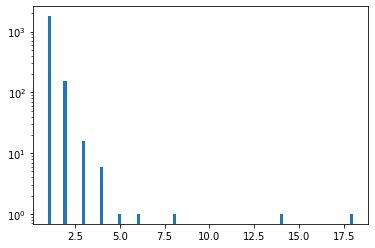

In [9]:
plt.hist(XYdf['cc_id'].value_counts(),bins=100)
plt.yscale('log')

No handles with labels found to put in legend.


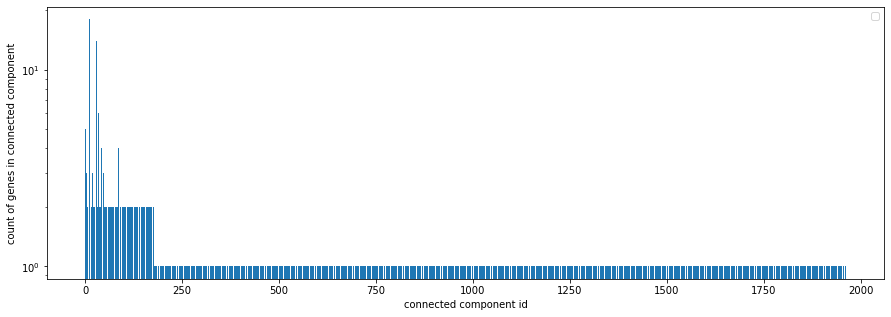

In [10]:
df_vc = XYdf['cc_id'].value_counts().reset_index()

plt.figure(figsize=(15,5))
plt.bar(df_vc['index'],df_vc['cc_id'])
plt.yscale('log')
plt.xlabel("connected component id")
plt.ylabel("count of genes in connected component")
plt.legend()
plt.show()


In [11]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit

In [12]:
dataset_groups = XYdf['cc_id'].values
gss = GroupShuffleSplit(n_splits=5, train_size=.8, random_state=42)


for i, (full_train_idxs,test_idxs) in enumerate(gss.split(XYdf,groups=dataset_groups)):
    full_train_df = XYdf.iloc[full_train_idxs].reset_index()
    test_df = XYdf.iloc[test_idxs].reset_index()
    train_groups = full_train_df['cc_id'].values
    
    train_val_group_split = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    train_idxs,val_idxs = next(train_val_group_split.split(
                                    full_train_df,
                                    groups=train_groups)
                               )
    train_df = full_train_df.iloc[train_idxs]
    val_df = full_train_df.iloc[val_idxs]
    
#     print(f"FTrain Test split {i}: \n\t{full_train_idxs[:10]} \n\t{test_idxs[:10]}")
#     print(f"Train Val split {i}: \n\t{train_idxs[:10]} \n\t{val_idxs[:10]}")
#     print()

#     print("Split", i)
#     print("__Train__")
#     display(train_df.head(10))
#     print("__Val__")
#     display(val_df.head(10))
#     print("__Test__")
#     display(test_df.head(10))
#     print()

    train_df.to_csv(f'data/synth_score_splits/cv{i}_train.tsv',index=False,sep='\t')
    val_df.to_csv(f'data/synth_score_splits/cv{i}_val.tsv',index=False,sep='\t')
    test_df.to_csv(f'data/synth_score_splits/cv{i}_test.tsv',index=False,sep='\t')
    


    
#     np.save(f'data/synth_score_splits/{i}_train.npy',train_idxs)
#     np.save(f'data/synth_score_splits{i}_test.npy',test_idxs)
    
#     re_train_idxs = np.load(f'data/mpra_splits/{i}_train.npy')
#     re_val_idxs = np.load(f'data/mpra_splits/{i}_val.npy')
#     print(f"reload {i}: \n\t{re_train_idxs[:10]} \n\t{re_val_idxs[:10]}")
    
#     train_df = full_train_df.iloc[re_train_idxs]
#     val_df = full_train_df.iloc[re_val_idxs]
    
#     display(train_df.head())
#     display(val_df.head())
    

In [13]:
tr0 = pd.read_csv('data/synth_score_splits/cv0_train.tsv',sep='\t')
tr1 = pd.read_csv('data/synth_score_splits/cv1_train.tsv',sep='\t')
tr2 = pd.read_csv('data/synth_score_splits/cv2_train.tsv',sep='\t')
tr3 = pd.read_csv('data/synth_score_splits/cv3_train.tsv',sep='\t')
tr4 = pd.read_csv('data/synth_score_splits/cv4_train.tsv',sep='\t')

In [14]:
tr0set = set(tr0['locus_tag'].values)
tr1set = set(tr1['locus_tag'].values)
tr2set = set(tr2['locus_tag'].values)
tr3set = set(tr3['locus_tag'].values)
tr4set = set(tr4['locus_tag'].values)

In [15]:
tr0set == tr3set

False

In [16]:
tr4

,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,score,cc_id
0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,5.00,178
1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,5.39,179
2,2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,5.43,180
3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,5.70,181
4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,5.37,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,2203,4175,EQU24_RS23110,CCTGCGTTGACCGCAGCCAGAACTTTTTTGATGAAAGTACGCAGAT...,4.378036,4.190754,3.680069,3.767275,4.026296,4.592859,...,4.482663,5.123590,5.319651,3.102884,3.996424,5.212666,6.668223,6.561774,4.98,1959
1408,2204,4176,EQU24_RS23115,TTCAAATCTTGCTTTGAGTCAGTAAATAGTAAGGTACTTTTGTTAA...,4.717098,4.252907,4.267814,4.094392,3.770267,4.027408,...,4.910349,6.346008,5.956263,4.465986,3.641980,5.050035,5.532330,5.051171,5.76,1960
1409,2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,5.32,171
1410,2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,5.29,1961


## Train/test split

In [17]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
#     sns.violinplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
#     plt.title(f"{title} distribution")
#     plt.show()
    
#     sns.boxplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True)
#     plt.title(f"{title} distribution")
#     plt.show()

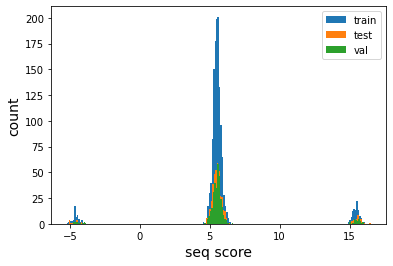

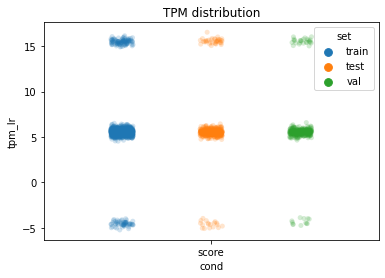

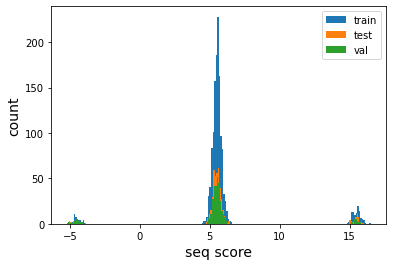

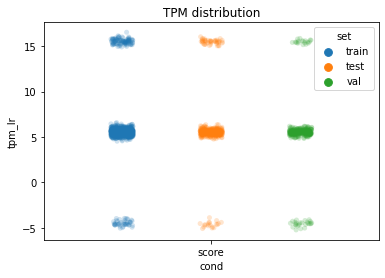

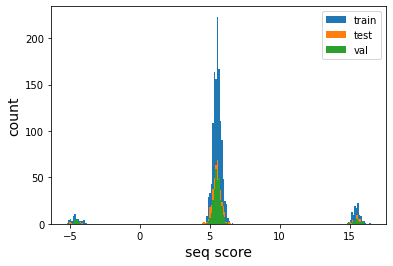

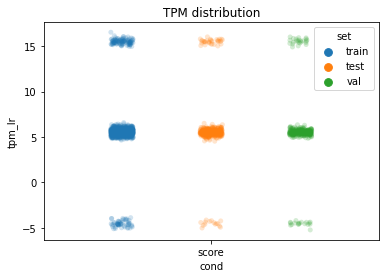

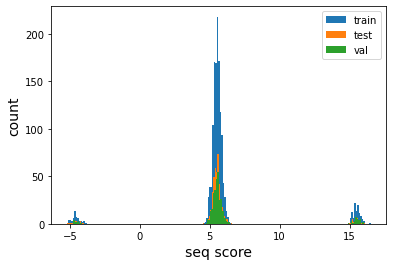

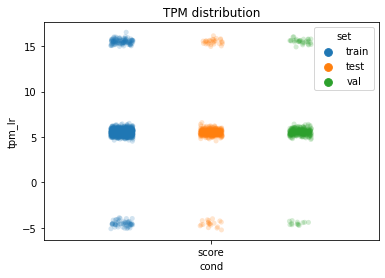

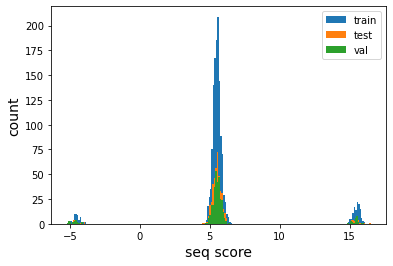

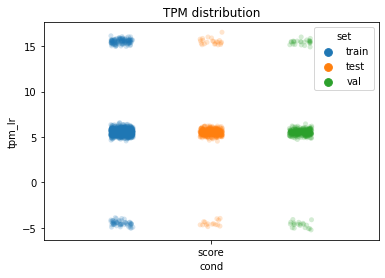

In [19]:
score_col = 'score'
for i in [0,1,2,3,4]:
    train_df = pd.read_csv(f'data/synth_score_splits/cv{i}_train.tsv',sep='\t')
    val_df = pd.read_csv(f'data/synth_score_splits/cv{i}_val.tsv',sep='\t')
    test_df = pd.read_csv(f'data/synth_score_splits/cv{i}_test.tsv',sep='\t')
    
    plot_train_test_hist(train_df, test_df,score_col=score_col,bins=200,val_df=val_df)
    view_train_test_dist(train_df, test_df,[score_col],"TPM",id_col='locus_tag',val_df=val_df)

    